# Using Textual Features and NLP Tools in Data Science
Based on a blop post in: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
<br>
Dataset Used:  (a 100k sample of) A million news headlines dataset from Kaggle (https://www.kaggle.com/therohk/million-headlines)
<br>
The topics we cover today:
* Basic statistic textual features 
* Stop Words
* N-grams
* Topic Modelling
* Lemmatizing
* Sentiment Analysis
* POS Tagging
* Readability 

## Libraries Loading

In [304]:


#NLP Libraries:
import nltk
import spacy
import gensim
import textstat

#Our standards:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set("talk")


## Import data

In [9]:
news = pd.read_csv('data/100k_headlines.csv')
news.head()

,publish_date,headline_text
0,20180507,cancer patients engaging in exercise show impr...
1,20180507,ccc corruption probe into horizon power it man...
2,20180507,changing attitudes to death can mean a new rol...
3,20180507,chart of the day budget most important issues
4,20180507,china retaliates after white house slams its w...


The dataset contains only two columns, the published date, and the news heading.



## Analyzing text statistics
Text statistics visualizations are simple but very insightful techniques. They include:

* word frequency analysis
* sentence length analysis
* average word length analysis

Those really help explore the fundamental characteristics of the text data.
<br>
To do so, we will be mostly using histograms (continuous data) and bar charts (categorical data).

<AxesSubplot:>

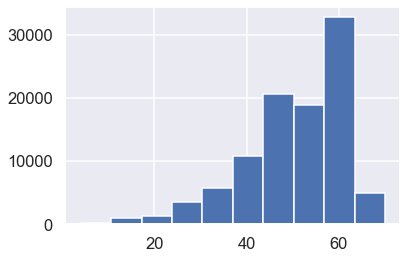

In [17]:
#number of characters histogram
news['headline_text'].str.len().hist()


Now, we will move on to data exploration at a word-level. 
<br>Let’s plot the number of words appearing in each news headline.



<AxesSubplot:>

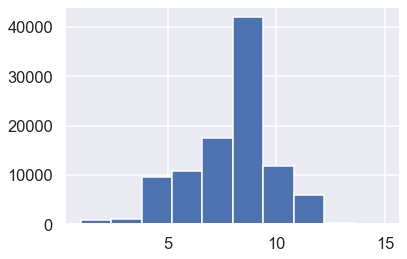

In [18]:
#number of words histogram:
news.headline_text.str.split().apply(lambda x: len(x)).hist()


<AxesSubplot:>

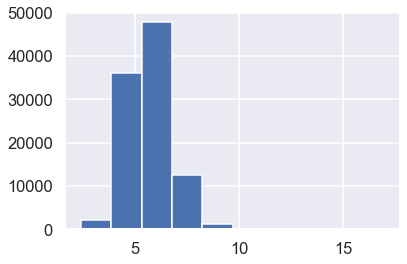

In [22]:
#average word length:
news['headline_text'].str.split(). \
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

The average word length ranges between 3 to 9 with 5 being the most common length. Does it mean that people are using really short words in news headlines?Let’s find out.

One reason why this may not be true is stopwords. Stopwords are the words that are most commonly used in any language such as “the”,” a”,” an” etc. As these words are probably small in length these words may have caused the above graph to be left-skewed.

Analyzing the amount and the types of stopwords can give us some good insights into the data.



## Analyzing Stop-Words

In [27]:
import nltk
from nltk.corpus import stopwords


In [31]:
english_sw = stopwords.words('english')
print(english_sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [328]:
#Creating a word corpus
new= news['headline_text'].str.split()
new=new.values.tolist()
wcorpus=[word for i in new for word in i]
print(wcorpus[:50])


['cancer', 'patients', 'engaging', 'in', 'exercise', 'show', 'improvement', 'ccc', 'corruption', 'probe', 'into', 'horizon', 'power', 'it', 'managers', 'changing', 'attitudes', 'to', 'death', 'can', 'mean', 'a', 'new', 'role', 'for', 'cemeteries', 'chart', 'of', 'the', 'day', 'budget', 'most', 'important', 'issues', 'china', 'retaliates', 'after', 'white', 'house', 'slams', 'its', 'warning', 'to', 'airlines', 'chinese', 'businessman', 'charged', 'with', 'attempted', 'bribery']


In [329]:
len(corpus)

10000

In [109]:
from collections import Counter
counter=Counter(wcorpus)
most=counter.most_common(10)

In [77]:
print(most)

[('to', 16266), ('in', 14161), ('of', 10507), ('the', 10335), ('for', 8877), ('coronavirus', 8381), ('on', 6271), ('and', 5102), ('with', 4641), ('a', 4115)]


We have many stopwords that are very "popular" in our popular.
<br>
Let's break it down

In [110]:
from collections import defaultdict
sw_dic=defaultdict(int)
all_dic=defaultdict(int)
for word in wcorpus:
    if word in english_sw:
        sw_dic[word]+=1
    else:
        all_dic[word]+=1

In [68]:
stop_counts = pd.Series(sw_dic)
stop_counts = stop_counts.sort_values(ascending=False)


how many stop words do we have in our corpus??

In [69]:
stop_counts.sum()/len(corpus)

0.17637665928639207

<AxesSubplot:>

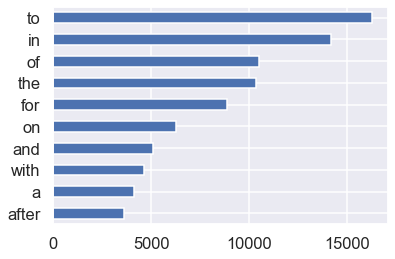

In [66]:
#most common stopwords:
stop_counts.head(10).sort_values().plot(kind='barh')

<AxesSubplot:>

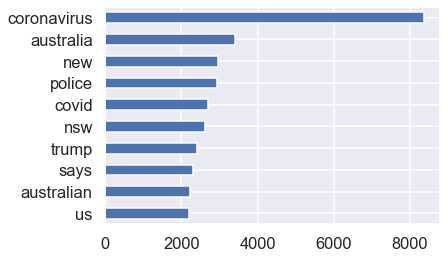

In [78]:
#most common non-stopwords: 
all_counts = pd.Series(all_dic)
all_counts = all_counts.sort_values(ascending=False)
all_counts.head(10).sort_values().plot(kind='barh')

## N-Grams
Ngrams are simply contiguous sequences of n words. For example “riverbank”,” The three musketeers” etc.
<br>
If the number of words is two, it is called bigram. For 3 words it is called a trigram and so on.
<br>
Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.

To implement n-grams we will use the ngrams function from nltk.util. For example:



In [81]:
from nltk.util import ngrams
list(ngrams(['I' ,'went','to','the','river','bank'],3))


[('I', 'went', 'to'),
 ('went', 'to', 'the'),
 ('to', 'the', 'river'),
 ('the', 'river', 'bank')]

Now that we know how to create n-grams lets visualize them.
<br>
To build a representation of our vocabulary we will use Countvectorizer. Countvectorizer is a simple method used to tokenize, vectorize and represent the corpus in an appropriate form. It is available in sklearn.feature_extraction.text


So with all this, we will analyze the top bigrams in our news headlines.

In [82]:
from sklearn.feature_extraction.text import CountVectorizer

In [114]:
sentences_corpus = list(news["headline_text"].values)

In [115]:
sentences_corpus[:5]

['cancer patients engaging in exercise show improvement',
 'ccc corruption probe into horizon power it managers',
 'changing attitudes to death can mean a new role for cemeteries',
 'chart of the day budget most important issues',
 'china retaliates after white house slams its warning to airlines']

In [181]:
cv = CountVectorizer(ngram_range=(2, 2),stop_words=english_sw)
vecs =cv.fit_transform(sentences_corpus)

Our CountVectorizer now have our "vocabulary" of bigrams

In [182]:
len(cv.vocabulary_)

356480

In [183]:
list(cv.vocabulary_)[:5]

['cancer patients',
 'patients engaging',
 'engaging exercise',
 'exercise show',
 'show improvement']

Our resulted matrix contain for each sentence - all the bigrams that appear in it

In [184]:
vecs.shape

(100000, 356480)

In [185]:
vecs.todense()[:5]

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

Lets sum the vectors to see how many appearances are there for each bigram:

In [186]:
sum_bigrams = vecs.sum(axis=0)


<AxesSubplot:>

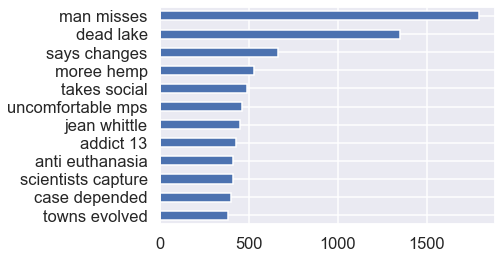

In [187]:
sum_series = pd.Series(sum_bigrams.A1,index=list(cv.vocabulary_))
sum_series.sort_values(ascending=False).head(12).sort_values().plot(kind='barh')

## Topic modeling exploration 

Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.
<br>
Latent Dirichlet Allocation (LDA) is an easy to use and efficient model for topic modeling. Each document is represented by the distribution of topics and each topic is represented by the distribution of words.

Once we categorize our documents in topics we can dig into further data exploration for each topic or topic group.



But before getting into topic modeling we have to pre-process our data a little. We will:

* Tokenize: the process by which sentences are converted to a list of tokens or words.
* Remove stopwords
* Lemmatize: reduces the inflectional forms of each word into a common base or root.
* Convert to the bag of words: Bag of words is a dictionary where the keys are words(or ngrams/tokens) and values are the number of times each word occurs in the corpus.

### Lemmatize??
Easy lemmatizing with spaCy.

spaCy is a relatively new in the space and is billed as an industrial strength NLP engine. It comes with pre-built models that can parse text and compute various NLP related features through one single function call. Ofcourse, it provides the lemma of the word too.



In [194]:
#import spacy
#python -m spacy download en_core_web_sm

In [221]:
nlp = spacy.load('en_core_web_sm')

Small Example:

In [200]:
sentence = "The striped bats are hanging on their feet for best"

In [222]:
doc = nlp(sentence)

In [223]:
" ".join([token.lemma_ for token in doc])

'the stripe bat be hang on their foot for good'

In [224]:
for i in sentences_corpus[:5]:
    print(i,"--->"," ".join([token.lemma_ for token in nlp(i)]))

cancer patients engaging in exercise show improvement ---> cancer patient engage in exercise show improvement
ccc corruption probe into horizon power it managers ---> ccc corruption probe into horizon power it manager
changing attitudes to death can mean a new role for cemeteries ---> change attitude to death can mean a new role for cemetery
chart of the day budget most important issues ---> chart of the day budget most important issue
china retaliates after white house slams its warning to airlines ---> china retaliate after white house slam its warning to airline


### Processing the corpus before LDA:

In [260]:
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.


In [253]:
corpus=[]

for sentence in tqdm(sentences_corpus[:10000]):
    doc = nlp(sentence)
    doc = lemmatizer(doc)
    doc = remove_stopwords(doc)
    corpus.append(doc)

100%|██████████| 10000/10000 [00:35<00:00, 284.01it/s]


In [259]:
for i in zip(sentences_corpus[:10],corpus[:10]):
    print(i[0],"--->",i[1])

cancer patients engaging in exercise show improvement ---> ['cancer', 'patient', 'engage', 'exercise', 'improvement']
ccc corruption probe into horizon power it managers ---> ['ccc', 'corruption', 'probe', 'horizon', 'power', 'manager']
changing attitudes to death can mean a new role for cemeteries ---> ['change', 'attitude', 'death', 'mean', 'new', 'role', 'cemetery']
chart of the day budget most important issues ---> ['chart', 'day', 'budget', 'important', 'issue']
china retaliates after white house slams its warning to airlines ---> ['china', 'retaliate', 'white', 'house', 'slam', 'warning', 'airline']
chinese businessman charged with attempted bribery in png ---> ['chinese', 'businessman', 'charge', 'attempt', 'bribery', 'png']
chinese police crack down on fake australian products ---> ['chinese', 'police', 'crack', 'fake', 'australian', 'product']
crewman still missing charter boat night crossing central qld ---> ['crewman', 'miss', 'charter', 'boat', 'night', 'cross', 'central', 

### Now we build a Bag-of-Word vectors:

In [261]:
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [262]:
bow_corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

In [263]:
corpus[0]

['cancer', 'patient', 'engage', 'exercise', 'improvement']

In [273]:
list(dict(dic).items())[:10]

[(0, 'cancer'),
 (1, 'engage'),
 (2, 'exercise'),
 (3, 'improvement'),
 (4, 'patient'),
 (5, 'ccc'),
 (6, 'corruption'),
 (7, 'horizon'),
 (8, 'manager'),
 (9, 'power')]

### Running the LDA model:

In [282]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 100, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 4)


In [283]:
lda_model.show_topics()[:5]

[(54,
  '0.051*"street" + 0.049*"month" + 0.043*"$" + 0.038*"study" + 0.035*"breach" + 0.032*"wall" + 0.030*"5" + 0.027*"stand" + 0.022*"poison" + 0.022*"toddler"'),
 (18,
  '0.097*"abuse" + 0.069*"community" + 0.055*"sex" + 0.050*"allege" + 0.047*"sexual" + 0.042*"address" + 0.039*"consider" + 0.036*"allegation" + 0.025*"robert" + 0.023*"19"'),
 (4,
  '0.133*"home" + 0.063*"care" + 0.061*"push" + 0.045*"john" + 0.043*"quiz" + 0.039*"near" + 0.033*"pfas" + 0.030*"aged" + 0.022*"despite" + 0.021*"forget"'),
 (34,
  '0.097*"china" + 0.078*"boy" + 0.075*"video" + 0.060*"russian" + 0.051*"facebook" + 0.047*"trade" + 0.041*"slow" + 0.032*"message" + 0.028*"problem" + 0.025*"tech"'),
 (23,
  '0.120*"tasmanian" + 0.072*"water" + 0.049*"daughter" + 0.048*"bring" + 0.039*"resident" + 0.032*"brexit" + 0.029*"cold" + 0.027*"strong" + 0.027*"pledge" + 0.024*"hearing"')]

### Visualize the LDA results:

In [284]:
import pyLDAvis
import pyLDAvis.gensim_models

In [285]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
64    -0.204116 -0.201243       1        1  2.766606
98    -0.058828 -0.020657       2        1  1.640797
65     0.039716 -0.153123       3        1  1.599713
49     0.149729 -0.143760       4        1  1.454312
16    -0.085587 -0.069787       5        1  1.422219
...         ...       ...     ...      ...       ...
51    -0.026073  0.079576      96        1  0.678090
75    -0.001533 -0.041349      97        1  0.674535
43     0.007169  0.049828      98        1  0.668436
31     0.018976  0.067683      99        1  0.660313
25     0.003541  0.085015     100        1  0.576100

[100 rows x 5 columns], topic_info=            Term        Freq       Total  Category  logprob  loglift
84         trump  370.000000  370.000000   Default  30.0000  30.0000
376        world  320.000000  320.000000   Default  29.0000  29.0000
36    australian  271.000000  271.000000   Default  28.0000  28.0000
39        police  303.000000  303.000000   Default  27.0000  27.0000
290    australia  301.000000  301.000000   Default  26.0000  26.0000
...          ...         ...         ...       ...      ...      ...
732       return    4.031409   55.594722  Topic100  -4.4646   2.5327
1937          14    2.949914   24.564883  Topic100  -4.7770   3.0371
570          kim    3.183639   52.690353  Topic100  -4.7007   2.3502
191          big    3.090614   96.077938  Topic100  -4.7304   1.7199
455         kill    2.988639  162.263522  Topic100  -4.7639   1.1622

[3802 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
493      21  0.088253       $
493      36  0.132379       $
493      39  0.154443       $
493      62  0.507454       $
493      99  0.088253       $
...     ...       ...     ...
8218     32  0.692565  zlatko
8218     49  0.173141  zlatko
1231     82  0.220168    zone
1231     89  0.660503    zone
363       4  0.848531     zoo

[4643 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[65, 99, 66, 50, 17, 61, 4, 28, 71, 57, 98, 30, 23, 72, 13, 20, 37, 49, 3, 88, 34, 82, 47, 41, 77, 51, 2, 59, 94, 45, 93, 19, 6, 80, 69, 43, 63, 54, 27, 100, 84, 33, 35, 5, 79, 78, 39, 74, 87, 53, 96, 92, 1, 85, 56, 73, 97, 15, 18, 42, 7, 55, 10, 81, 58, 24, 46, 40, 89, 48, 75, 67, 95, 11, 38, 9, 90, 70, 21, 25, 83, 62, 60, 86, 16, 68, 91, 64, 12, 29, 31, 36, 8, 14, 22, 52, 76, 44, 32, 26])

## Sentiment Analysis using NLTK

In [289]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

In [290]:
sid = SentimentIntensityAnalyzer()

In [299]:
sentence = "The food was great" 
#sentence = "The food was great!!" 
vs = sid.polarity_scores(sentence)
print("{:-<65} {}".format(sentence, str(vs)))

The food was great----------------------------------------------- {'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}


Let's apply it to the news:

In [300]:
def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

In [301]:
news['polarity']=news['headline_text'].\
    map(lambda x: get_vader_score(x))
polarity=news['polarity'].replace({0:'neg',1:'neu',2:'pos'})

<AxesSubplot:>

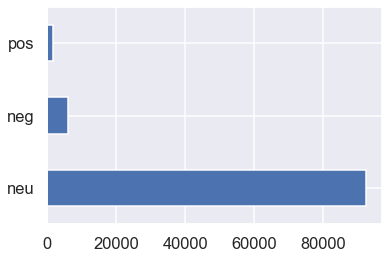

In [303]:
polarity.value_counts().plot(kind='barh')

## Parts of Speech (POS) Tagging
Parts of speech (POS) tagging is a method that assigns part of speech labels to words in a sentence. For example:

* Noun (NN)- Joseph, London, table, cat, teacher, pen, city
* Verb (VB)- read, speak, run, eat, play, live, walk, have, like, are, is
* Adjective(JJ)- beautiful, happy, sad, young, fun, three


In [311]:
from nltk import word_tokenize
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [312]:

sentence="The greatest comeback stories in 2019"
tokens=word_tokenize(sentence)
nltk.pos_tag(tokens)

[('The', 'DT'),
 ('greatest', 'JJS'),
 ('comeback', 'NN'),
 ('stories', 'NNS'),
 ('in', 'IN'),
 ('2019', 'CD')]

### Example: Let's see what are the most common adjectives

<AxesSubplot:>

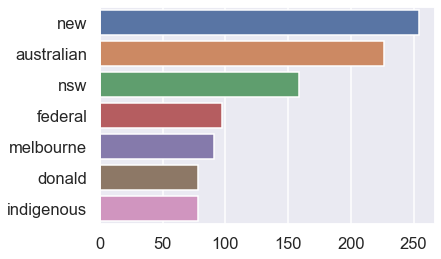

In [315]:
def get_adjs(text):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if 'JJ' in tag:
            adj.append(word)
    return adj


words=news['headline_text'].sample(10000).apply(lambda x : get_adjs(x))
words=[x for l in words for x in l]
counter=Counter(words)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

## Text complexity Assessment via TextStat

It can be very informative to know how readable (difficult to read) the text is and what type of reader can fully understand it. Do we need a college degree to understand the message or a first-grader can clearly see what the point is?

You can actually put a number called readability index on a document or text. Readability index is a numeric value that indicates how difficult (or easy) it is to read and understand a text.



In [318]:
from textstat import flesch_reading_ease

readability = news['headline_text'].apply(lambda x : flesch_reading_ease(x))

<AxesSubplot:>

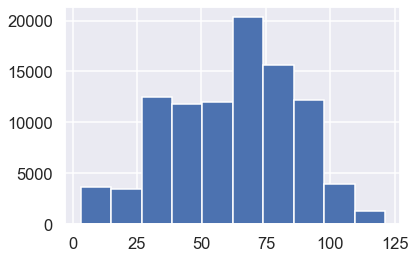

In [320]:
readability[readability>=0].hist()

Almost all of the readability scores fall above 60. This means that an average 11-year-old student can read and understand the news headlines. 
<br>Let’s check all news headlines that have a readability score below 5.

In [324]:
news.headline_text[readability<20].head().values

array(['multiple sclerosis diagnosis prompts volunteering',
       'nsw government pledges body modification crackdown',
       'tasmania reworked child protection system criticised',
       'nsw government reviews confucius classrooms program',
       'researchers study antimicrobial properties of leptospermum honey'],
      dtype=object)

Let's see easy-to-read sentences:

In [325]:
news.headline_text[readability>90].head().values

array(['harvey takes his first steps', 'i am that girl',
       'john edwards speaks to the business',
       'kings cross rape case that put consent on trial',
       'more than just a game: may 7'], dtype=object)